# Complex Cross Correlation Performance

The purpose of this notebook is to investigate the sensitivity of complex cross correlation for speckle tracking to various parameters. Note, all experiment assume a zero phase gradient across the patches. In reality, phase gradients are present and will reduce performance. For much of the interior of the ice sheet where gradients are small, however, complex correlation works quite well. For simplicity, all experiments assume small offsets (< 1 pixel). As a result, circular convolution is used. In actuality, a zero padded buffer may be needed to expand the search radius, but the peformance with respect to the parameters examined here should be similar. For further simplicity, all matches will be performed with a square windows (though the code can support rectangular windows.)

In [ ]:
import psutil
import os

## Supporting Code

The results in this notebook make use of a supporting set of python functions that can be found at: https://github.com/fastice/nisarfunc. To install, go to a directory in your Python path (if you haven't set a Python path you will need to; google "setting python path".) The necesary functions are then imported as:

In [2]:
import nisarfunc as nf

Other packages that are used are imported as (you may need to install if they don't load):

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2

Note these experiments use an fft to oversample the correlation peak to obtain subpixel results. The code is written so that a different peak interpolator can be used. Specifically, the cross correlation is defined as `nccPatches(...subPix=osSubPix, subPixArgs=(10, 4), subPixKwArgs={})` so that the oversampling is accomplished as `subPix(*subPixArgs, **subPixKwArgs)`.

Since the simulations are can be time consuming if a lot of realizations are used, the code can be multi-threaded to run `nJobs` as:

    speckleJobs = nf.speckleJobs(myFunction) # Setup an object to multi-thread myFunction 
    speckleJobs.runNInstances(nJobs, arg1, arg2,..,keyw1=....) 
    results = speckleJobs.results # list with nJob elements, each containing a thread output 
    speckleJobs.reset() # Reset to run a fresh set (otherwise results will be accumulated)

### Number of Instances

More samples will improve the quality of the estimates, but take longer to run. The variable `nInstances` is used by all simulations. It can be set to a low number for debugging and notebook demonstration and to a larger number to generate higher fidelity results.

In [4]:
nInstances = 1000

## Window Size

The search window size for correlation matching is an important parameter in matching. In generally, larger windows should yield cleaner matches, but with some caveats. As windows get larger, the potential for phase gradients to reduce correlation increases. Furthermore, larger windows yield lower resolution. In addition, there is always some quantization error depending on how finely the peak can be resolve, so at some point that can set a noise floor so that larger windows produce little added benefit. In such cases, its likely better to average results from several smaller windows, which reduce quantization noise. 

The following function will simulate white noise patches with a specified level of correlation $\rho$ and subpixel row and column offsets ($\delta_r$ and $\delta_c$). The cross correlation algorithm will then return estimates of these offsets ($\hat{\delta_r}$ and $\hat{\delta_c}$). The routine will then return the errors ($e_r = \hat{\delta_r} - \delta_r$ and $e_c = \hat{\delta_c} - \delta_c$).

In [5]:
def cmpxWindowSize(ws, rho, osPeak, osBox, overSample=False):
    # randomize both the osFactor and offset to vary offsets
    osFactor = random.randint(6,8)  # Oversample factor used to generate shifts, so shifts in increments of 1/osFactor
    #osPeak, osBox = 40, 4  # Oversample peak
    deltaR, deltaC = random.randint(1, osFactor-1), random.randint(1, osFactor-1)  # Randomly vary offsets to avoid an single offset bias
    patchS, patchR = nf.correlatedShiftedPatches(ws, ws, deltaR, deltaC, rho, overSample=osFactor, sigma=1.0)  # sim data
    deltaRHat, deltaCHat, cmax, _, _ = nf.nccPatches(patchS, patchR, subPixArgs=(osPeak, osBox),overSampleCorr=overSample, ampMatch=False)
    return deltaRHat - deltaR/osFactor, deltaCHat - deltaC/osFactor

The results in many of the following examples can be plotted as:

In [6]:
def plotErrorAndSuccessRate(resultsSigma, percentSuccess, rhos, windows, title='', \
                            xlabel='Window Size (pixels)', ylabels=['Error (pixels)', '% success']):
    fig, myAxes = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    for rho in rhos:
        myAxes[0].plot(windows, resultsSigma[rho],'*-', label=rho)
        myAxes[1].plot(windows, resultsPercent[rho],'*-', label=rho)
    for myAxis, xlab, ylab in zip(myAxes, [xlabel] * 2, ylabels):
        myAxis.legend()
        myAxis.set_xlabel(xlab, fontSize=14)
        myAxis.set_ylabel(ylab, fontSize=14)

Using this function, the following code will simulate errors for several window sizes for low (.2) medium (0.5) and high (0.8) correlation.

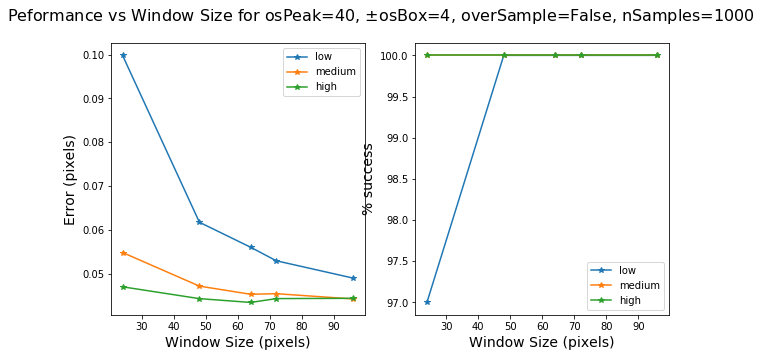

In [7]:
windows = [24, 48, 64, 72, 96]
rhos = {'low': 0.2, 'medium' : 0.5, 'high' : 0.8}
overSample = False
speckleJobs = nf.speckleJobs(cmpxWindowSize)
resultsSigma = {rho : [] for rho in rhos}
resultsPercent = {rho : [] for rho in rhos}
osPeak, osBox = 40, 4
for rho in rhos:
    for window in windows:
        print(f'\rrho={rhos[rho]} window {window} ', end='')
        speckleJobs.runNInstances(nInstances, window, rhos[rho], osPeak, osBox, overSample=overSample)
        tmp = np.array(speckleJobs.results)
        resultsSigma[rho].append(np.nanstd(tmp))
        percentSuccess = np.sum(np.isfinite(tmp)) / (tmp.shape[0] * tmp.shape[1]) * 100.
        resultsPercent[rho].append(percentSuccess)
        speckleJobs.reset()
plotErrorAndSuccessRate(resultsSigma, resultsPercent, rhos, windows,\
                        title=f'Peformance vs Window Size for osPeak={osPeak}, $\pm$osBox={osBox}, '
                        f'overSample={overSample}, nSamples={nInstances}')

**Figure 1. Matching performance as a function of window size with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to complex correlation value of $\rho=0.2$ (low), $\rho=0.5$ (medium), and $\rho=0.8$ (high)**

## Oversampling

Oversampling can be important for detected images, but should make little difference for complex matching, except for its effect on the peak oversampling. In this example, the complex data are oversampled, but the p

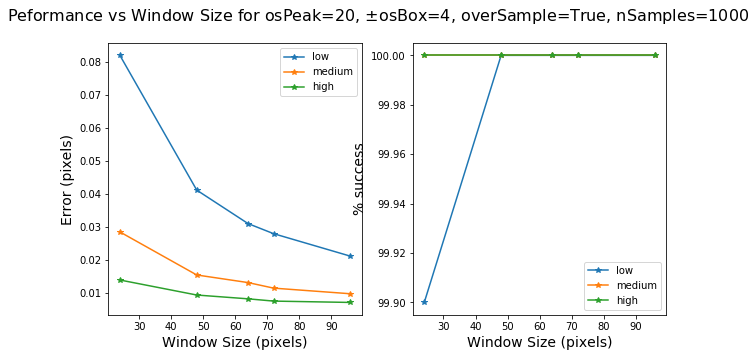

In [8]:
windows = [24, 48, 64, 72, 96]
rhos = {'low': 0.2, 'medium' : 0.5, 'high' : 0.8}
overSample = True
speckleJobs = nf.speckleJobs(cmpxWindowSize)
resultsSigma = {rho : [] for rho in rhos}
resultsPercent = {rho : [] for rho in rhos}
osPeak, osBox = 20, 4
for rho in rhos:
    for window in windows:
        print(f'\rrho={rhos[rho]} window {window} ', end='')
        speckleJobs.runNInstances(nInstances, window, rhos[rho], osPeak, osBox, overSample=overSample)
        tmp = np.array(speckleJobs.results)
        resultsSigma[rho].append(np.nanstd(tmp))
        percentSuccess = np.sum(np.isfinite(tmp)) / (tmp.shape[0]*tmp.shape[1]) * 100.
        resultsPercent[rho].append(percentSuccess)
        speckleJobs.reset()
plotErrorAndSuccessRate(resultsSigma, resultsPercent, rhos, windows,
                        title=f'Peformance vs Window Size for osPeak={osPeak}, $\pm$osBox={osBox}, '
                        f'overSample={overSample}, nSamples={nInstances}')

**Figure 2. Matching performance as a function of window size with 2xpatch overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to complex correlation value of $\rho=0.2$ (low), $\rho=0.5$ (medium), and $\rho=0.8$ (high)**

## Peak Oversample Factor

There are multiple ways to oversample the peak the range from oversamping to fitting some functional form (polynomial or Gaussian). A simple and straight forward approach is to extract the region with $\pm$`osBox` around the correlation peak, oversample that by a factor `osPeak`, and then find the subpixel maximimum from this result. Since the peak cannot be oversampled with infinite precision, there should be an upper limits on `osBox` and `osPeak` after which the point of diminishing returns is reached. The code evaluates the accuracy (or at least precission) of the oversampling operations over a range of `osBox` and `osPeak` values.

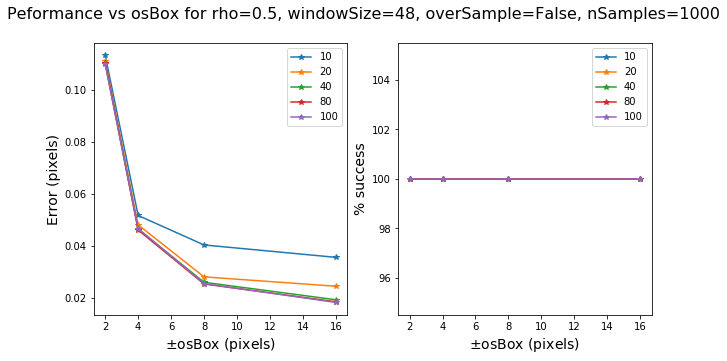

In [9]:
window = 48
rho = 0.5
overSample = False
speckleJobs = nf.speckleJobs(cmpxWindowSize)
osPeaks, osBoxes = [10, 20, 40, 80, 100], [2, 4, 8, 16]
resultsSigma = {str(osPeak) : [] for osPeak in osPeaks}
resultsPercent = {str(osPeak) : [] for osPeak in osPeaks}
#
for osPeak in osPeaks:
    for osBox in osBoxes:
        print(f'\rosBox={osBox} osPeak {osPeak} ', end='')
        speckleJobs.runNInstances(nInstances, window, rho, osPeak, osBox, overSample=overSample)
        tmp = np.array(speckleJobs.results)
        resultsSigma[str(osPeak)].append(np.nanstd(tmp))
        percentSuccess = np.sum(np.isfinite(tmp)) / (tmp.shape[0]*tmp.shape[1]) * 100.
        resultsPercent[str(osPeak)].append(percentSuccess)
        speckleJobs.reset()
#
plotErrorAndSuccessRate(resultsSigma, resultsPercent, [str(osPeak) for osPeak in osPeaks], osBoxes,
                        xlabel='$\pm$osBox (pixels)',
                        title=f'Peformance vs osBox for rho={rho}, windowSize={window}, '
                        f'overSample={overSample}, nSamples={nInstances}')

**Figure 3. Matching performance as a function of oversampled area around the peak ($\pm$'osBox') with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

The results shown above indicate a value of `osBox=8` is near the point of diminishing returns with virtually no improvement for `osPeak > 40`, with reasonably acceptable results with `osPeak=20`. When the patch is initially oversampled (see Oversamplign above), however, the performance is batter than that shown here. Thus, the patch oversampling experiment can be combined with the peak oversampling for the code shown below. Note in the oversampler, 'osBox' is scaled by the 2x oversample factor, so it represents the same value in single pixel values. 

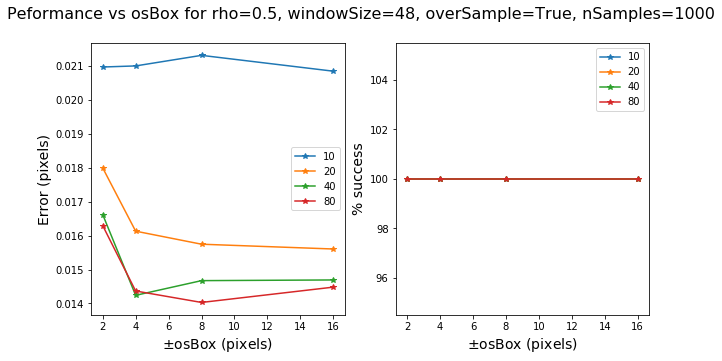

In [10]:
window = 48
rho = 0.5
overSample = True
speckleJobs = nf.speckleJobs(cmpxWindowSize)
osPeaks, osBoxes = [10, 20, 40, 80], [2, 4, 8, 16]  # drop the 100 box
resultsSigma = {str(osPeak) : [] for osPeak in osPeaks}
resultsPercent = {str(osPeak) : [] for osPeak in osPeaks}
#
for osPeak in osPeaks:
    for osBox in osBoxes:
        print(f'\rosBox={osBox} osPeak {osPeak} ', end='')
        speckleJobs.runNInstances(nInstances, window, rho, osPeak, osBox, overSample=overSample)
        tmp = np.array(speckleJobs.results)
        resultsSigma[str(osPeak)].append(np.nanstd(tmp))
        percentSuccess = np.sum(np.isfinite(tmp)) / (tmp.shape[0]*tmp.shape[1]) * 100.
        resultsPercent[str(osPeak)].append(percentSuccess)
        speckleJobs.reset()
#
plotErrorAndSuccessRate(resultsSigma, resultsPercent, [str(osPeak) for osPeak in osPeaks], osBoxes,
                        xlabel='$\pm$osBox (pixels)',
                        title=f'Peformance vs osBox for rho={rho}, windowSize={window}, '
                        f'overSample={overSample}, nSamples={nInstances}')

**Figure 4. Matching performance as a function of oversampled area around the peak ($\pm$'osBox') with no overampling prior to correlation in terms of (left) error and (right) probability of success. Curves correspond to different over sampling factors (`osPeak`).**

The results above are consistent with first two experiments focused on window size. Notably, the sub-pixel accuracy seems greatly improved when the complex data are oversampled prior to matching. For complex matching, the oversampling can be accomplished using a NxN forward transform on each patch, the spectra can then be multiplied, and then the inverse transformed with a 2Nx2N transform after zero padding. In this case with `osPeak=20` and `osBox=4`, the fft width is 20x2x2x4=160 (one factor of 2 for $\pm$osBox and the other to acount for the 2x oversampling as described above.) By contrast, for no oversampling, `osPeak=20` and `osBox=8` yields quantization error about twice as large, for a peak oversampling fft of the same size (160=20x2x8). The 2x patch oversampling adds cost (substituting one 48x48 FFT for a 96x96 FFT), but that cost should be small relative to the larger FFT needed for oversampling. And a net computational savings can realized with `osPeak=10` and `osBox=2 or 4`. 

## Conclusions

The plots shown above reveal several import performance characteristics of speckle-tracking methods applied to complex data. Specifically:
* Complex correlation produces robust matches even at low levels of correlation (e.g., $\rho=0.2$). 
* For the two higher $\rho$ cases performance is relatively insenstive to window size. For $\rho=0.2$ there is a substantial difference in performance. But ignoring other factors, $n$ 24x24 pixel estimates could be performed more cheaply as single window of dimension 24$n$x$24n$ and the 1/n peformance improvement after averaging should more than make up the difference. If phase gradients had been present, the relative performance of smaller windows would improve further.
* Although not strictly required to remove aliasing effects, 2x oversampling of the data prior to cross correlation appears to improve performance signicantly. Any increase in cost, can likely be offset by adusting the oversampling routine.
* There is a limit on how finely the correlation peak can be oversampled. The quantization level in terms of the error is given by:  $\Delta=\sqrt{12}\sigma$. In the examples above the best case $\sigma$ values are ~0.028 and ~0.014 for no- and 2x-oversampling, respectively. The corresponding quantization levels are $\Delta=0.096$ and $\Delta=0.048$ or about 1/tenth and 1/twenthieth of a pixel. Although these numbers are for moderate correlation, Figures 1 and 2 indicate peformanc will not signifantly better even with $\rho=0.8$.

In [14]:
0.014 * np.sqrt(12)

0.04849742261192856